In [1]:
from eeg_data_load import load_eeg_data

class_labels = [
    "Normal",
    "Complex_Partial_Seizures",
    "Electrographic_Seizures",
    "Video_detected_Seizures_with_no_visual_change_over_EEG",
]

train_path = "/kaggle/input/eeg-data-final/EEG_Data/train_data"
val_path = "/kaggle/input/eeg-data-final/EEG_Data/validation_data"

In [2]:
X_train, y_train = load_eeg_data(train_path, class_labels)
X_val, y_val = load_eeg_data(val_path, class_labels)

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from scipy.signal import welch
import pywt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [11]:
def extract_time_domain_features(signals):
    """Extract time domain features from EEG signals.
    Args:
        signals: Shape (samples, channels, time_points)
    Returns:
        features: Shape (samples, n_features)
    """
    n_samples = signals.shape[0]
    features_list = []
    
    for sample in range(n_samples):
        sample_features = []
        for channel in range(signals.shape[1]):
            channel_signal = signals[sample, channel, :]
            
            # Basic statistics
            mean = np.mean(channel_signal)
            std = np.std(channel_signal)
            max_val = np.max(channel_signal)
            min_val = np.min(channel_signal)
            
            # Zero crossing rate
            zero_crossings = np.sum(np.abs(np.diff(np.signbit(channel_signal))))
            
            # Activity measures
            rms = np.sqrt(np.mean(channel_signal**2))
            mean_abs = np.mean(np.abs(channel_signal))
            
            # Shape statistics
            kurtosis = stats.kurtosis(channel_signal)
            skewness = stats.skew(channel_signal)
            
            # Hjorth parameters
            diff_first = np.diff(channel_signal)
            diff_second = np.diff(diff_first)
            mobility = np.std(diff_first) / np.std(channel_signal)
            complexity = np.std(diff_second) / np.std(diff_first)
            
            channel_features = [
                mean, std, max_val, min_val, zero_crossings,
                rms, mean_abs, kurtosis, skewness,
                mobility, complexity
            ]
            sample_features.extend(channel_features)
        
        features_list.append(sample_features)
    
    return np.array(features_list)

In [4]:
def extract_frequency_domain_features(signals, sampling_rate=256):
    """Extract frequency domain features from EEG signals.
    Args:
        signals: Shape (samples, channels, time_points)
        sampling_rate: Sampling frequency in Hz
    Returns:
        features: Shape (samples, n_features)
    """
    n_samples = signals.shape[0]
    features_list = []
    
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    
    for sample in range(n_samples):
        sample_features = []
        for channel in range(signals.shape[1]):
            channel_signal = signals[sample, channel, :]
            
            # Compute power spectral density
            freqs, psd = welch(channel_signal, fs=sampling_rate)
            
            # Calculate band powers
            band_powers = {}
            for band_name, (low, high) in bands.items():
                mask = (freqs >= low) & (freqs <= high)
                band_powers[band_name] = np.mean(psd[mask])
            
            # Spectral edge frequency (95% of power)
            total_power = np.cumsum(psd)
            total_power = total_power / total_power[-1]
            spectral_edge = freqs[np.where(total_power >= 0.95)[0][0]]
            
            channel_features = [
                band_powers['delta'],
                band_powers['theta'],
                band_powers['alpha'],
                band_powers['beta'],
                band_powers['gamma'],
                spectral_edge
            ]
            sample_features.extend(channel_features)
        
        features_list.append(sample_features)
    
    return np.array(features_list)

In [5]:
def extract_connectivity_features(signals):
    """Extract connectivity features between EEG channels.
    Args:
        signals: Shape (samples, channels, time_points)
    Returns:
        features: Shape (samples, n_features)
    """
    n_samples = signals.shape[0]
    features_list = []
    
    for sample in range(n_samples):
        sample_features = []
        n_channels = signals.shape[1]
        
        # Cross-correlation and coherence
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                sig_i = signals[sample, i, :]
                sig_j = signals[sample, j, :]
                
                # Cross-correlation
                correlation = np.corrcoef(sig_i, sig_j)[0, 1]
                
                # Coherence (simplified)
                coh = np.abs(np.correlate(sig_i, sig_j)).max()
                
                sample_features.extend([correlation, coh])
        
        features_list.append(sample_features)
    
    return np.array(features_list)

In [6]:
def extract_wavelet_features(signals):
    """Extract wavelet-based features from EEG signals.
    Args:
        signals: Shape (samples, channels, time_points)
    Returns:
        features: Shape (samples, n_features)
    """
    n_samples = signals.shape[0]
    features_list = []
    wavelet = 'db4'
    level = 4
    
    for sample in range(n_samples):
        sample_features = []
        for channel in range(signals.shape[1]):
            channel_signal = signals[sample, channel, :]
            
            # Decompose signal
            coeffs = pywt.wavedec(channel_signal, wavelet, level=level)
            
            # Extract features from each coefficient level
            for coeff in coeffs:
                # Statistical features
                feat_mean = np.mean(coeff)
                feat_std = np.std(coeff)
                feat_energy = np.sum(coeff**2)
                
                level_features = [feat_mean, feat_std, feat_energy]
                sample_features.extend(level_features)
        
        features_list.append(sample_features)
    
    return np.array(features_list)

In [7]:
def combine_features(signals, normalize=True):
    """Combine all features and optionally normalize.
    Args:
        signals: Shape (samples, channels, time_points)
        normalize: Whether to normalize features
    Returns:
        features: Shape (samples, n_total_features)
    """
    # Extract all feature types
    time_features = extract_time_domain_features(signals)
    freq_features = extract_frequency_domain_features(signals)
    wavelet_features = extract_wavelet_features(signals)
    conn_features = extract_connectivity_features(signals)
    
    # Combine features
    all_features = np.concatenate([
        time_features,
        freq_features,
        wavelet_features,
        conn_features
    ], axis=1)
    
    if normalize:
        scaler = StandardScaler()
        all_features = scaler.fit_transform(all_features)
    
    return all_features

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = self.bn2(self.fc2(out))
        out += identity
        return F.relu(out)

In [9]:
class EEGClassifier(nn.Module):
    def __init__(self, input_size, num_classes=4):
        super(EEGClassifier, self).__init__()
        
        # Initial dimension reduction
        self.fc_input = nn.Linear(input_size, 512)
        self.bn_input = nn.BatchNorm1d(512)
        
        # Attention mechanism
        self.attention1 = AttentionBlock(512)
        
        # Residual blocks
        self.res_block1 = ResidualBlock(512, 256)
        self.res_block2 = ResidualBlock(512, 256)
        
        # Second attention layer
        self.attention2 = AttentionBlock(512)
        
        # Final classification layers
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        # Initial processing
        x = F.relu(self.bn_input(self.fc_input(x)))
        
        # First attention mechanism
        x = self.attention1(x)
        
        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        
        # Second attention mechanism
        x = self.attention2(x)
        
        # Final classification
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [12]:
X_train_features = combine_features(X_train)
X_val_features  = combine_features(X_val)

In [13]:
X_train_tensor = torch.tensor(X_train_features, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_features, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [14]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [16]:
input_size = X_train_features.shape[1]
model = EEGClassifier(input_size=input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
EEGClassifier                            --
├─Linear: 1-1                            486,912
├─BatchNorm1d: 1-2                       1,024
├─AttentionBlock: 1-3                    --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  65,664
│    │    └─ReLU: 3-2                    --
│    │    └─Linear: 3-3                  66,048
│    │    └─Sigmoid: 3-4                 --
├─ResidualBlock: 1-4                     --
│    └─Linear: 2-2                       131,328
│    └─Linear: 2-3                       131,584
│    └─BatchNorm1d: 2-4                  512
│    └─BatchNorm1d: 2-5                  1,024
│    └─Dropout: 2-6                      --
├─ResidualBlock: 1-5                     --
│    └─Linear: 2-7                       131,328
│    └─Linear: 2-8                       131,584
│    └─BatchNorm1d: 2-9                  512
│    └─BatchNorm1d: 2-10                 1,024
│    └─Dropout: 2-11       

In [18]:
from tqdm import tqdm 

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    best_val_acc = 0
    best_model = None
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        # Training with progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for inputs, labels in train_loader_tqdm:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            train_loader_tqdm.set_postfix(train_loss=epoch_train_loss / (train_loader_tqdm.n + 1))  # Update the progress bar

        # Validation
        model.eval()
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
            for inputs, labels in val_loader_tqdm:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
                val_loader_tqdm.set_postfix(val_loss=epoch_val_loss / (val_loader_tqdm.n + 1))  # Update the progress bar
        
        # Record losses
        training_losses.append(epoch_train_loss / len(train_loader))
        validation_losses.append(epoch_val_loss / len(val_loader))
        
        # Check if this is the best model
        val_acc = balanced_accuracy_score(val_labels, val_preds)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict().copy()
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    model.load_state_dict(best_model)
    return model, training_losses, validation_losses


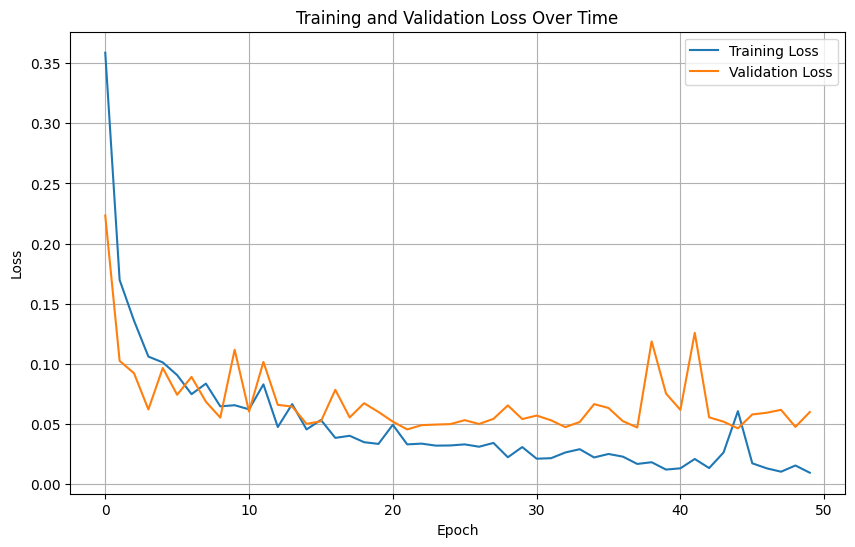

In [19]:
model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer)

In [20]:
def evaluate_model(model, test_loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] 
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1) 
            probs = torch.softmax(outputs, dim=1)  
            
            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())   
            all_probs.extend(probs.cpu().numpy())  
    
    # Calculate the classification report and balanced accuracy
    classification_report_result = classification_report(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    
    # Compute the AUC-ROC score for multi-class classification (One-vs-Rest)
    auc_roc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='macro')

    # Print the outputs
    print("Classification Report:\n", classification_report_result)
    print("Balanced Accuracy:", balanced_accuracy)
    print("AUC-ROC Score:", auc_roc)
    
    return {
        'classification_report': classification_report_result,
        'balanced_accuracy': balanced_accuracy,
        'auc_roc': auc_roc
    }

In [21]:
results = evaluate_model(model, val_loader, 4)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       696
           1       0.99      0.98      0.98       549
           2       1.00      0.99      0.99       137
           3       1.00      1.00      1.00        21

    accuracy                           0.99      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.99      0.99      0.99      1403

Balanced Accuracy: 0.9897376364916739
AUC-ROC Score: 0.9985380098248596


In [22]:
torch.save(model, 'EEG Classification.pth')